<a href="https://colab.research.google.com/github/lauramoraes/Analise_de_Clusters/blob/master/8%20-%20Clusteriza%C3%A7%C3%A3o%20Hier%C3%A1rquica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização Hierárquica


### Importando bibliotecas a serem usadas

In [3]:
install.packages("quantmod")
install.packages("lubridate")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’



In [0]:
suppressMessages(suppressWarnings(library(quantmod)))
suppressMessages(suppressWarnings(library(lubridate)))

In [0]:
# Funcao para baixar os valores de um simbolo e gerar um resultado bool que
# denota se a ação subiu em cada dia
download_symbol_up = function(symbol) {
  
  # Por padrão a getSymbols simplesmente salva uma variável nova no escopo
  # global. Se passarmos auto.assign=FALSE, não faz isso e retorna o valor.
  # Isso é importante porque precisamos ter controle sobre o nome da variável
  # no qual o valor vai ser armazenado, pra podermos operar no resto da função
  values = getSymbols(symbol, auto.assign = FALSE)
  
  # values vem com várias colunas, incluindo <symbol>.Open e <symbol>.Close.
  # Vamos pegar essas duas e criar uma <symbol>.Up que vai ser TRUE se 
  # Close > Open.
  
  # Primeiro passo: montar as strings com o nome das colunas (entrada e saída)
  open_name = paste(symbol, "Open", sep=".")
  close_name = paste(symbol, "Close", sep=".")
  
  # Segundo passo: calcular a coluna da variação relativa. Usar indexação
  # por colunas.
  variation = values[, close_name]#/values[, open_name] - 1
  
  # Terceiro passo: renomear a coluna que acabamos de criar para a <symbol>.up
  names(variation) <- symbol
  
  return(variation)
}

# Função para fazer o merge de duas tabelas no formato XTS de forma certa
merge_symbols = function(x, y) {
  # Ao especificarmos join="inner", garantimos que o merge só vai incluir
  # linhas correspondente a dias que estão em ambas as séries temporais.
  return(merge(x, y, join="inner"))
}

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

Warning message:
“ELET3.SA contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”

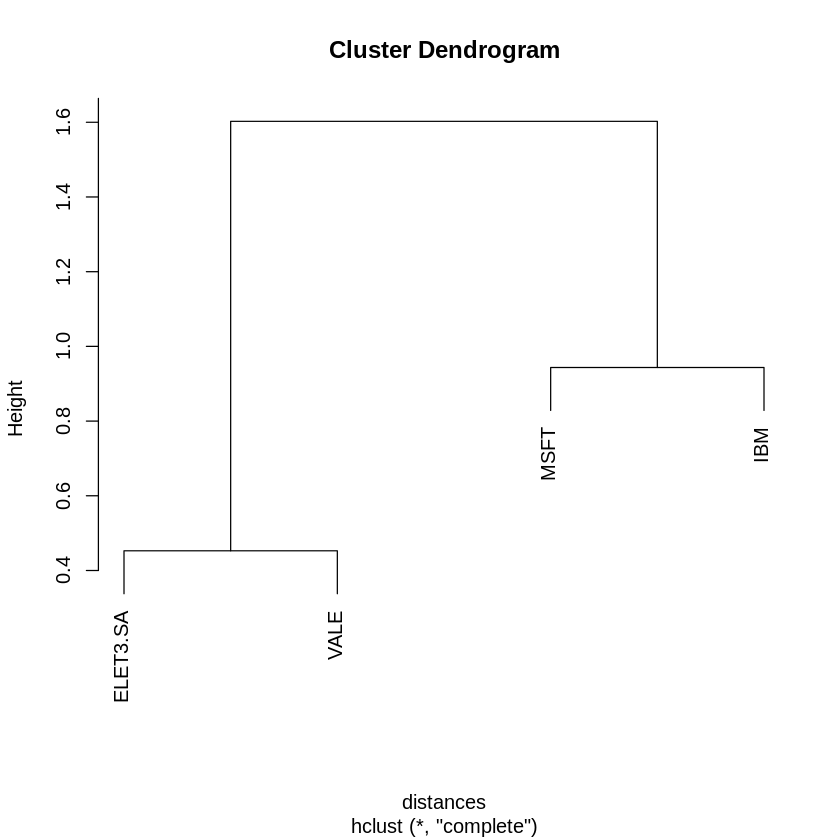

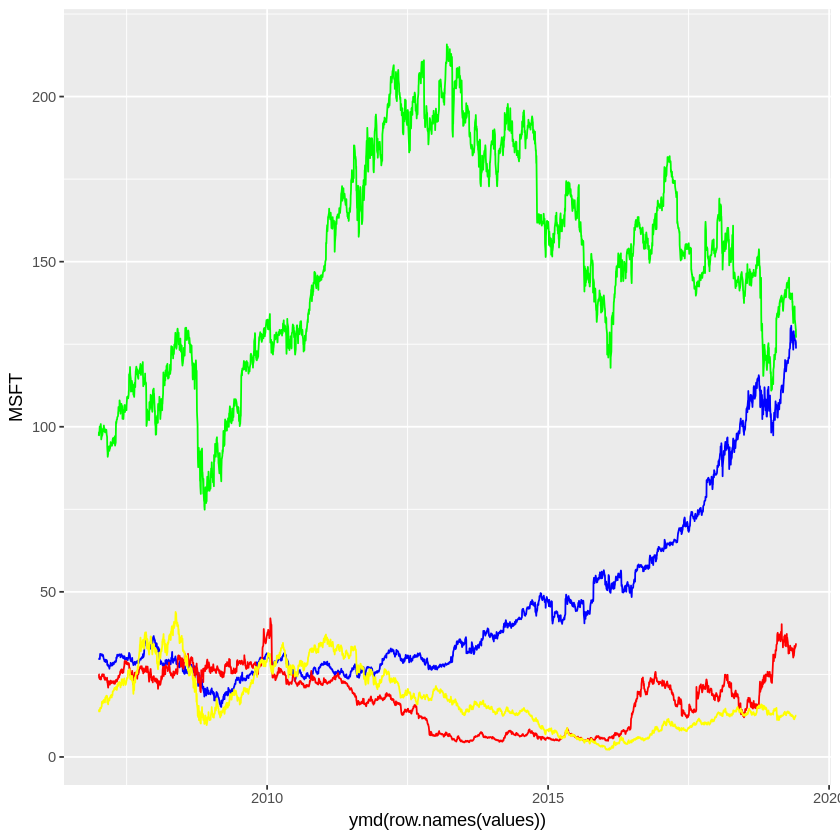

Joining, by = "symbol"
Warning message:
“Column `symbol` joining character vector and factor, coercing into character vector”

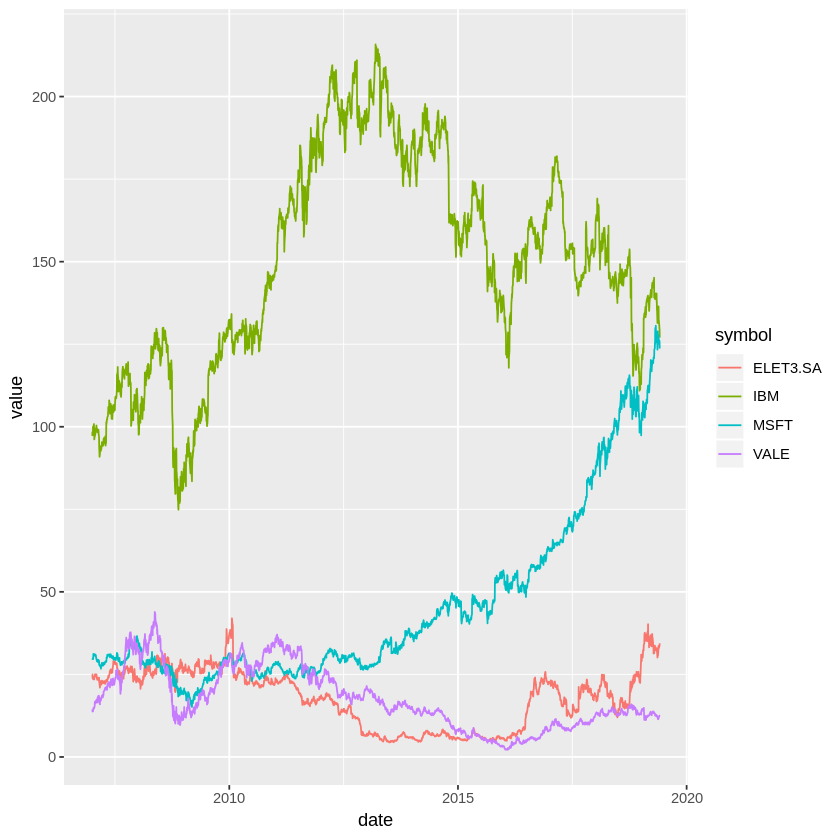

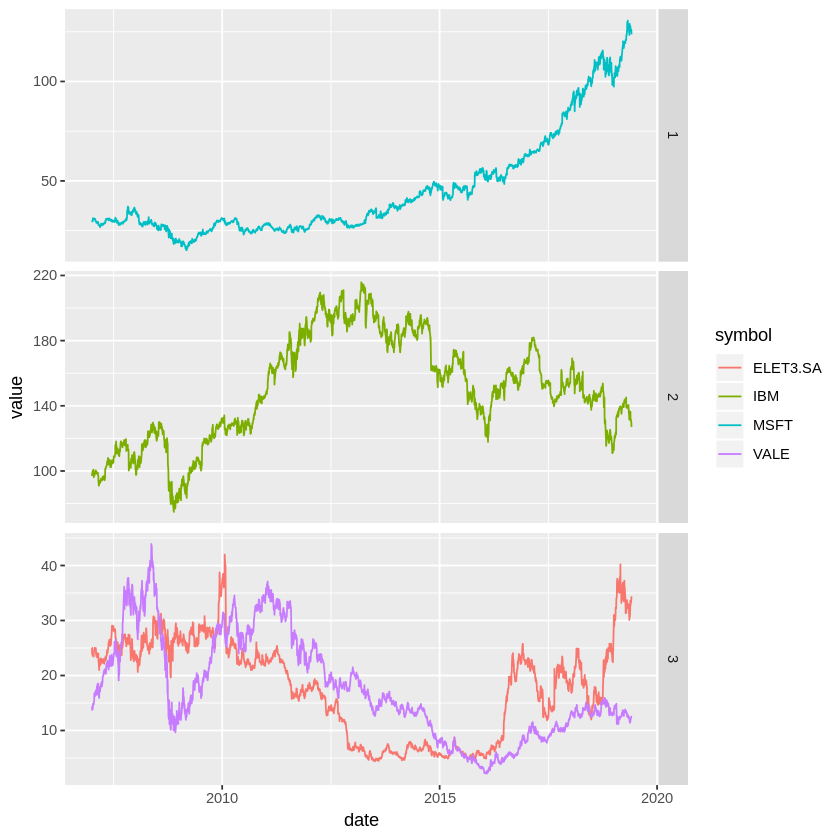

In [7]:
# Vetor de símbolos para baixarmos. Colocar aqui quantos símbolos quiser.
symbols = c("MSFT", "IBM", "ELET3.SA", "VALE")

# O mapply vai chamar a função download_symbol_up para cada elemento do vetor
# symbols, e retornar na forma de uma Lista
values_list = mapply(download_symbol_up, symbols)

# O Reduce vai pegar os dois primeiros elementos da lista values_up_list,
# executar a merge_symbols com ele, e botar o resultado de volta na lista. Ele
# repete isso até só haver um resultado, que vai ser a concatenação de todas
# as colunas
values = Reduce(merge_symbols, values_list)

# Values agora deve estar no ponto pra ser transformada em um data.frame
# ou tibble, e passada para a análise de associação.
values = na.omit(data.frame(values))

n_cols = ncol(values)

dist_mat = matrix(0, nrow = n_cols, ncol = n_cols)
colnames(dist_mat) = colnames(values)
rownames(dist_mat) = colnames(values)

for (i in 1:n_cols) {
  for (j in i:n_cols) {
    result = ccf(values[, i], values[, j], plot = FALSE)
    max_cor = max(result$acf)
    dist_mat[i, j] = 1 - max_cor
    dist_mat[j, i] = 1 - max_cor
  }
}

distances = as.dist(dist_mat)
clusters = hclust(distances)
plot(clusters)

clusters_cut = cutree(clusters, k=3)

# Plotando, metodo1

ggplot(values, aes(x=ymd(row.names(values)))) + 
  geom_line(aes(y=MSFT), color="blue") + 
  geom_line(aes(y=IBM), color="green") + 
  geom_line(aes(y=ELET3.SA), color="red") +
  geom_line(aes(y=VALE), color="yellow")

# Plotando, metodo2

# Criando uma coluna "date", devidamente convertida
values["date"] = as.Date(row.names(values))


gather(values, key=symbol, value=value, -date) %>% 
  ggplot(aes(x=date, y=value)) + 
  geom_line(aes(color=symbol))

# Plotando separando por clusters

clusters_df = data.frame(
  symbol = names(clusters_cut),
  cluster = clusters_cut
  
)

gather(values, key=symbol, value=value, -date) %>% 
  left_join(clusters_df) %>%
  ggplot(aes(x=date, y=value)) + 
  geom_line(aes(color=symbol)) +
  facet_grid(rows = vars(cluster), scales = "free_y")
